In [2]:
import os
import pickle
import re

import torch

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import interp1d

In [ ]:
def read_data(data_dir):
    data = {}
    for prefix in ['activations', 'errors', 'weights', 'gradients']:
        file_path = os.path.join(data_dir, f'{prefix}.pkl')

        if os.path.exists(file_path):
            with open(file_path, 'rb') as file:
                data[prefix] = pickle.load(file)
                print(f"Loaded {prefix} successfully.")
        else:
            print(f"File for {prefix} not found.")
    return data

In [ ]:
def plot_distribution(ax, data, label, xlabel=False):
    exp = np.floor(np.log2(np.abs(data[data != 0]))).astype(int)
    exp = np.clip(exp, -126, 127)
    bins = np.linspace(exp.min(), exp.max(), exp.max() - exp.min() + 1)
    counts, bins, patches = ax.hist(exp, bins=bins, density=True, edgecolor='black')

    ax.axvspan(-12, 12, color='grey', alpha=0.3)
    ax.axvspan(-9, 8, color='grey', alpha=0.3)

    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%0.0f'))
    ax.set_xlim(xmin=-60, xmax=15)
    ax.set_yticks(ax.get_yticks()[1:-1])  # Exclude first and last y-tick to prevent overlap
    ax.text(-58, ax.get_ylim()[1] * 0.88, label, fontsize=20)  # Label position

    plt.setp(ax.get_xticklabels(), visible=xlabel)

# Flatten the activation, weights, and activations gradients into a single array
train_data = read_data('data/sst2_train/step_500')
activations = np.concatenate([tensor.flatten() for tensor in train_data['activations'].values()])
weights = np.concatenate([tensor.flatten() for tensor in train_data['weights'].values()])
errors = np.concatenate([tensor.flatten() for tensor in train_data['errors'].values()])

fig = plt.figure(figsize=(10, 8), dpi=100)
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0)
labels = ["activation", "weight", "gradient"]

for i, array in enumerate([activations, weights, errors]):
    ax = plt.subplot(gs[i])
    if i == 2:
        array = array * 1024
    plot_distribution(ax, array, label=labels[i], xlabel=(i == 2))

    if i == 1:
        ax.set_ylabel("Density", fontsize=20, labelpad=10)
    if i == 2:
        ax.set_xlabel("Exponent Value", fontsize=20)

plt.subplots_adjust(left=0.15, top=0.90, bottom=0.10, right=0.95)
plt.savefig('mobilebert_tensors.png', transparent=True, bbox_inches='tight', pad_inches=0.1)


In [ ]:
def concatenate_tensors(tensor_dict):
    concatenated = {}
    for key, value in tensor_dict.items():
        if (match := re.search(r"mobilebert.encoder.layer.(\d+).(.+)", key)) is not None:
            concatenated.setdefault(match.group(2), []).append(value)

    # Concatenating tensors for each name
    for layer_name in concatenated:
        concatenated[layer_name] = np.concatenate(concatenated[layer_name])

    return concatenated

squad_data = read_data('data/squad_inference/step_0')
grouped_activations = concatenate_tensors(squad_data['activations'])

# Initialize plot settings
plt.clf()
plt.figure(figsize=(10, 8), dpi=100)

# Constants for labels
fontsize_label, fontsize_ticks = 20, 16

# Plotting each activation distribution
def plot_dist(inputs, label, linewidth=2, num_points=500):
    exp = np.floor(np.log2(np.abs(inputs[inputs != 0]))).astype(int)

    num_bins = exp.max() - exp.min()
    hist, bin_edges = np.histogram(exp, bins=num_bins, density=True)
    bin_edges = bin_edges[1:]

    x = np.linspace(bin_edges.min(), bin_edges.max(), num_points)
    f = interp1d(bin_edges, hist, 'quadratic')

    plt.plot(x, f(x), label=label, linewidth=linewidth)

for k, v in grouped_activations.items():
    plot_dist(v, k, linewidth=3)

# Configure plot appearance
plt.xlim(left=-15, right=15)
plt.xlabel('Exponent Value', fontsize=fontsize_label)
plt.ylabel('Density', fontsize=fontsize_label)
plt.xticks(fontsize=fontsize_ticks)
plt.yticks(fontsize=fontsize_ticks)

# Adding shaded regions to the plot
shaded_regions = [(-2, 2), (-4, 4), (-6, 6), (-8, 8)]
shaded_alpha = [0.3, 0.51, 0.657, 0.759]
for region, alpha in zip(shaded_regions, shaded_alpha):
    plt.axvspan(region[0], region[1], color='grey', alpha=0.3)

# Creating and adding legend handles
labels = ['1 bit', '2 bits', '3 bits', '4 bits']
handles = [mpatches.Patch(color='grey', alpha=a, label=l) for a, l in zip(shaded_alpha, labels)]
plt.legend(handles=handles, loc='upper left', fontsize=fontsize_label)

# Save the plot to a file
plt.savefig('mobilebert_activation.png', bbox_inches='tight', transparent=True)


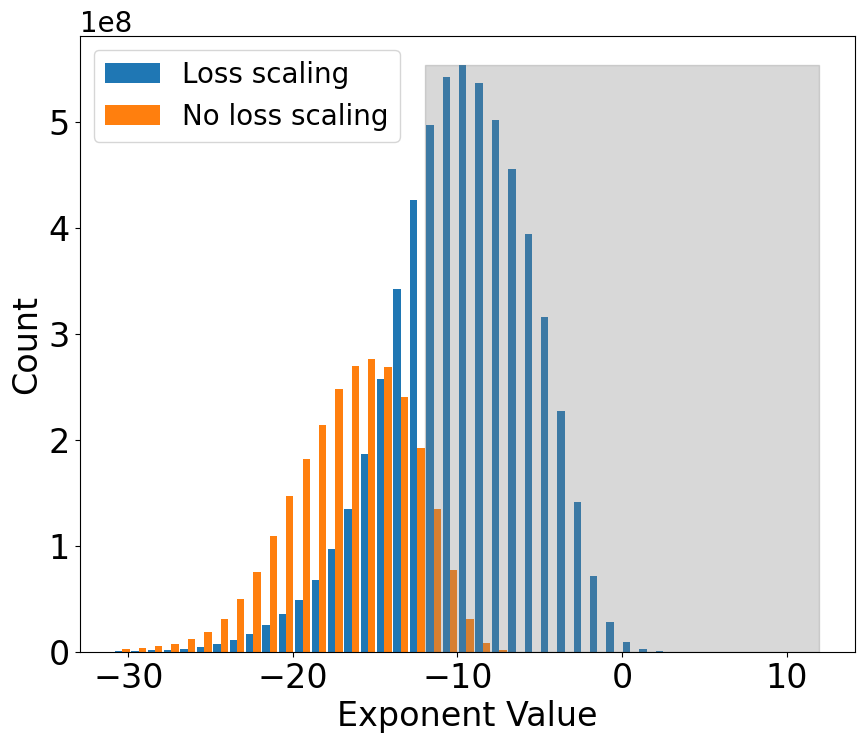

In [4]:
hist1 = torch.load("/data/home/jeffreyy/quantized-training/minotaur/data/mobilebert-tiny-mrpc/epoch_6/histogram.pt").cpu()
hist2 = torch.load("/data/home/jeffreyy/quantized-training/minotaur/data/mobilebert-tiny-mrpc-no-loss-scaling/epoch_6/histogram.pt").cpu()

# Plot exponent values from -30 to 10
min_bin, max_bin = 96, 136

hist1 = hist1[min_bin:max_bin + 1]
hist2 = hist2[min_bin:max_bin + 1]

bins = torch.linspace(-126, 127, 255)
bins = bins[min_bin:max_bin + 2]
bar_width = (bins[1] - bins[0]) * 0.45

plt.figure(figsize=(10, 8))
plt.bar(bins[:-1] - bar_width/2, hist1, width=bar_width, label='Loss scaling')
plt.bar(bins[:-1] + bar_width/2, hist2, width=bar_width, label='No loss scaling')

plt.fill_betweenx([0, max(max(hist1), max(hist2))], -12, 12, color='gray', alpha=0.3)

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'

plt.xlabel('Exponent Value', fontsize=24)
plt.ylabel('Count', fontsize=24)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

ax = plt.gca()
ax.yaxis.get_offset_text().set_fontsize(20)

plt.legend(fontsize=20, loc='upper left')

plt.savefig("plots/loss_scaling")